# 1. The useful packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 2. ATTENTION! If this is not executed in colab, this cell doesn't need to be run

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

# please change the path below to where this file is
%cd drive/MyDrive/computerVis

# 3. This is the function which apply gaussian smoothing to the given image

In [2]:
def gaussian_smoothing(img):
  """ apply gaussian filter to the given image

  Parameters
  ----------
  img: {ndarray} shape = [row * col]
        The img that is given, Which is denoted with an ndarray,
        for example 128*128 means 128 rows by 128 columns.

  Returns
  -------
  ans: {ndarray} shape = [row * col]
        The result after gaussian filtering, which is the same size 
        as the input image.

  """

  # The gaussian filter refering professor's instruction
  filter = np.array([[1, 1, 2, 2, 2, 1, 1], 
                     [1, 2, 2, 4, 2, 2, 1],
                     [2, 2, 4, 8, 4, 2, 2],
                     [2, 4, 8, 16, 8, 4, 2],
                     [2, 2, 4, 8, 4, 2, 2],
                     [1, 2, 2, 4, 2, 2, 1],
                     [1, 1, 2, 2, 2, 1, 1]], dtype = np.float16)
  
  # The answer initialized with all 0s, same shape as the input image
  ans = np.zeros([img.shape[0],img.shape[1]], dtype = np.float16) 

  # The procedure of doing the convolution
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      for m in range(filter.shape[0]):
        for n in range(filter.shape[1]):
          if(i - filter.shape[0] // 2 < 0 or i + filter.shape[0] // 2 >= img.shape[0] or 
             j - filter.shape[1] // 2 < 0 or j + filter.shape[1] // 2 >= img.shape[1]):
            continue
          else:
            ans[i, j] += filter[m, n] * img[i - 3 + m, j - 3 + n]

  # we have to divide it by 140 to normalize the result
  return np.divide(ans, 140)

# 4. This is the function that computes the gradients of both axis

In [3]:
def gradient_operation(img):
  """ compute the horizontal and vertical gradient

  Parameters
  ----------
  img: {ndarray} shape = [row * col]
        the input image that we want to compute the gradient

  Returns
  -------
  grad_hori: {ndarray} shape = [row * col]
              the horizontal gradient, same shape as the input

  grad_vert: {ndarray} shape = [row * col]
              the vertical gradient, same shape as the input
  """

  # The Prewitt operator with vertical and horizontal orientation
  Prewitt_X = np.array([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]], dtype=np.float16)
  
  Prewitt_Y = np.array([[1, 1, 1],
                        [0, 0, 0],
                        [-1, -1, -1]], dtype=np.float16)
  
  # The answers initialized with all 0s, same shape as the input image
  grad_hori = np.zeros([img.shape[0],img.shape[1]], dtype = np.float16) 

  grad_vert = np.zeros([img.shape[0],img.shape[1]], dtype = np.float16)

  # The procedure of doing the convolution
  # Since the two operators are of the same shape, we can do it with one iteration
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      for m in range(Prewitt_X.shape[0]):
        for n in range(Prewitt_X.shape[1]):
          if(i - Prewitt_X.shape[0] // 2 < 0 + 3 or i + Prewitt_X.shape[0] // 2 >= img.shape[0] - 3 or 
             j - Prewitt_X.shape[1] // 2 < 0 + 3 or j + Prewitt_X.shape[1] // 2 >= img.shape[1] - 3):
            continue
          else:
            grad_hori[i, j] += Prewitt_X[m, n] * img[i - 1 + m, j - 1 + n]
            grad_vert[i, j] += Prewitt_Y[m, n] * img[i - 1 + m, j - 1 + n]
  
  return grad_hori, grad_vert

# 5. This function generates gradient magnitude and gradient angle

In [4]:
def generate_magnitude_direction(grad_hori, grad_vert):
  """
  Parameters
  ----------
  grad_hori: {ndarray} shape = [row * col]
              the horizontal gradient of an image

  grad_vert: {ndarray} shape = [row * col]
              the vertical gradient of an image

  Returns
  -------
  gradient: {ndarray} shape = [row * col]
              the gradient magnitude of an image at each pixel
  
  direction: {ndarray} shape = [row * col]
              the gradient angle of an image at each pixel
  """

  # np.hypot does (x^2 + y^2)^(0.5) at each pixel
  gradient = np.hypot(grad_hori, grad_vert) 

  # np.arctan2 generates the answer within the range [-pi, pi], which corresponds to the algorithm
  direction = np.arctan2(grad_vert, grad_hori)

  return gradient, direction

# 6. This function applies non-maxima-suppression with the give gradient and angle

In [5]:
def non_maxima_suppression(gradient, direction):
  """
  Parameters
  ----------
  gradient: {ndarray} shape = [row * col]
              the gradient magnitude of an image at each pixel

  direction: {ndarray} shape = [row * col]
              the gradient angle of an image at each pixel

  Returns
  -------
  magnitude: {ndarray} shape = [row * col]
              the gradient magnitude of an image at each pixel after non-maxima-suppression
  """

  # the generated magnitude should be of the same shape as the input
  magnitude = np.zeros([gradient.shape[0],gradient.shape[1]], dtype = np.float16)

  # change from radians to degree for easy calculation
  direction = direction * 180 / np.pi + 180

  # non-maxima-suppression 
  # since gradient is already normalized, we don't have to normalize again
  for i in range(1, gradient.shape[0]-1):
    for j in range(1, gradient.shape[1]-1):
      try: 
        if (0 <= direction[i, j] < 22.5 or 157.5 <= direction[i, j] < 202.5 or 337.5 <= direction[i, j] <= 360):
          if(gradient[i, j]>=gradient[i, j+1] and gradient[i, j]>=gradient[i, j-1]):
            magnitude[i, j] = gradient[i, j]

        elif (22.5 <= direction[i, j] < 67.5 or 202.5 <= direction[i, j] < 247.5):
          if(gradient[i, j]>=gradient[i-1, j+1] and gradient[i, j]>=gradient[i+1, j-1]):
            magnitude[i, j] = gradient[i, j]

        elif (67.5 <= direction[i, j] < 112.5 or 247.5 <= direction[i, j] < 292.5):
          if(gradient[i, j]>=gradient[i+1, j] and gradient[i, j]>=gradient[i-1, j]):
            magnitude[i, j] = gradient[i, j]

        elif (112.5 <= direction[i, j] < 157.5 or 292.5 <= direction[i, j] < 337.5):
          if(gradient[i, j]>=gradient[i-1, j-1] and gradient[i, j]>=gradient[i+1, j+1]):
            magnitude[i, j] = gradient[i, j]
      except Exception:
        continue

  return magnitude

# 7. This function takes the whole gradient magnitude and try to provide the p-tile algorithm

In [32]:
def p_tile(magnitude, p=0.25):
  """
  Parameters
  ----------
  magnitude: {ndarray} shape = [row * col]
              the gradient magnitude of an image at each pixel

  p: double
      the percentage in p-tile algorithm

  Returns
  -------
  magnitude_after_p_tile: {ndarray} shape = [row * col]
              the gradient magnitude of an image at each pixel after p-tile
  """

  # num is the number of valid magnitude in the image
  num = np.count_nonzero(magnitude)

  # standard is the standard to role out some small magnitude
  standard = int(p * num)

  # find the largest 'standard' number of magnitude by first ravel and then find the largest
  index = np.argpartition(magnitude.ravel(), -standard)[-standard:]
  i2d = np.unravel_index(index, magnitude.shape)

  # only keep the largest 'standard' number of magnitude
  magnitude_after_p_tile = np.zeros([magnitude.shape[0], magnitude.shape[1]], dtype = np.float16)
  magnitude_after_p_tile[i2d] = magnitude[i2d]

  # the bitmap only shows if it is part of the edge
  magnitude_after_p_tile[magnitude_after_p_tile>0] = 255

  return magnitude_after_p_tile

# 8. The main function begins here

# 8.1 Read file and apply gaussian smoothing

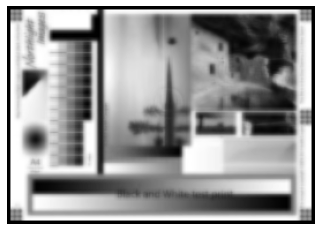

In [40]:
# Please be noted that in this experiment, all of the results are float numbers, so to show the image we have to convert into int.
# if it is another file, please change the 'FILE' variable
# FILE = "House.bmp"
FILE = "Test patterns.bmp"

# open the image and convert it to grayscale, then convert to numpy array
img = Image.open(FILE).convert('L')
img = np.asarray(img)

# applies gaussian smoothing and shows the result
after_gaussian = gaussian_smoothing(img)
plt.axis('off')
plt.imshow(after_gaussian.astype(np.int16), cmap = 'gray')

# 8.2 find the vertical and horizontal gradient of the image

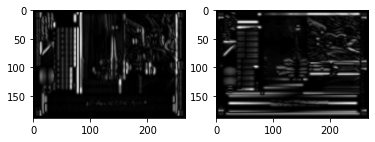

In [41]:
# computes the gradients of both direction
grad_hori, grad_vert = gradient_operation(after_gaussian)

# shows the results
plt.figure()
plt.axis('off')
plt.subplot(1, 2, 1)

# after Prewitt operation, the range becomes [-255*3, 255*3]. 
# Take the absolute value and it becomes [0, 255*3], then divided by 3 makes the result [0, 255]

plt.imshow((np.absolute(grad_hori)/3).astype(np.int16), cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow((np.absolute(grad_vert)/3).astype(np.int16), cmap = 'gray')
plt.show()

# 8.3 find the gradient magnitude and edge angle of the image

371.5
3.14


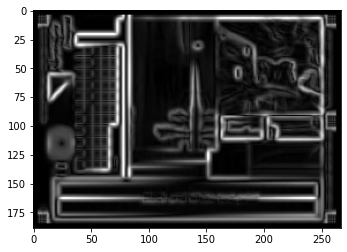

In [42]:
gradient, direction = generate_magnitude_direction(grad_hori, grad_vert)
print(np.max(gradient))
print(np.max(direction))

# Here I used gradient/max(gradient) * 255 to normalize the image
# If normalize by sqrt(max(grad_hori)^2+max(grad_vert)^2), most part wouldn't be seen.
plt.imshow((gradient.astype(np.int16))/np.max(gradient.astype(np.int16)) *255, cmap = 'gray')

# 8.4 find the magnitude after non_maxima_suppression

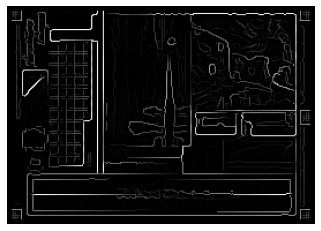

In [43]:
magnitude = non_maxima_suppression(gradient, direction)
plt.axis('off')
plt.imshow(magnitude.astype(np.int16), cmap = 'gray')

# 8.5 Use p-tile to filter the edges

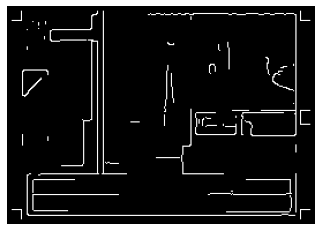

In [44]:
# this is p-tile when p == 25%
edge_25 = p_tile(magnitude, p=0.25)
plt.axis('off')
plt.imshow(edge_25.astype(np.int16), cmap = 'gray')

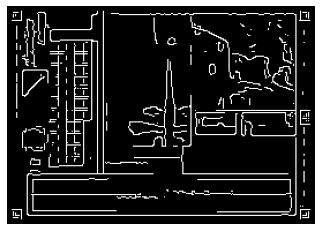

In [45]:
# this is p-tile when p == 50%
edge_50 = p_tile(magnitude, p=0.5)
plt.axis('off')
plt.imshow(edge_50.astype(np.int16), cmap = 'gray')

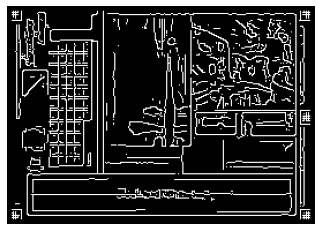

In [46]:
# this is p-tile when p == 75%
edge_75 = p_tile(magnitude, p=0.75)
plt.axis('off')
plt.imshow(edge_75.astype(np.int16), cmap = 'gray')

# 9. save the above images

In [47]:
# The reasons that some of the variables are modified are the same as in their corresponding cells.
plt.imsave("test_after_gaussian.png", after_gaussian.astype(np.int16), cmap = 'gray')
plt.imsave("test_horizontal_grad.png", (np.absolute(grad_hori)/3).astype(np.int16), cmap = 'gray')
plt.imsave("test_vertical_grad.png", (np.absolute(grad_vert)/3).astype(np.int16), cmap = 'gray')
plt.imsave("test_gradient.png", (gradient.astype(np.int16))/np.max(gradient.astype(np.int16)) *255, cmap = 'gray')
plt.imsave("test_after_suppression.png", magnitude.astype(np.int16), cmap = 'gray')
plt.imsave("test_edge_25.png", edge_25.astype(np.int16), cmap = 'gray')
plt.imsave("test_edge_50.png", edge_50.astype(np.int16), cmap = 'gray')
plt.imsave("test_edge_75.png", edge_75.astype(np.int16), cmap = 'gray')